In [55]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
import warnings



In [56]:
DATASET_DIRECTORY = '/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/'

In [57]:

from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    GREEN = "\033[32m"
    YELLOW = "\033[33m"
    BLUE = "\033[34m"
    MAGENTA = "\033[35m"
    CYAN = "\033[36m"
    WHITE = "\033[37m"
    BOLD = "\033[1m"
    NORMAL = "\033[0m"

X_columns = [
    'flow_duration', 'header_length', 'protocol_type', 'duration',
    'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp',
    'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min',
    'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitude',
    'radius', 'covariance', 'variance', 'weight'
]

y_column = 'label'

dict_34_classes = {'BenignTraffic': 0,
                    'DDoS-RSTFINFlood' :1, 'DDoS-PSHACK_Flood':2,  'DDoS-SYN_Flood':3, 'DDoS-UDP_Flood':4, 'DDoS-TCP_Flood':5, 
                    'DDoS-ICMP_Flood':6, 'DDoS-SynonymousIP_Flood':7, 'DDoS-ACK_Fragmentation':8, 'DDoS-UDP_Fragmentation':9, 'DDoS-ICMP_Fragmentation':10, 
                    'DDoS-SlowLoris':11, 'DDoS-HTTP_Flood':12, 'DoS-UDP_Flood':13, 'DoS-SYN_Flood':14, 'DoS-TCP_Flood':15, 'DoS-HTTP_Flood':16,
                    'Mirai-greeth_flood': 17, 'Mirai-greip_flood': 18, 'Mirai-udpplain': 19,
                    'Recon-PingSweep': 20, 'Recon-OSScan': 21, 'Recon-PortScan': 22, 'VulnerabilityScan': 23, 'Recon-HostDiscovery': 24,
                    'DNS_Spoofing': 25, 'MITM-ArpSpoofing': 26,
                    'BrowserHijacking': 27, 'Backdoor_Malware': 28, 'XSS': 29, 'Uploading_Attack': 30, 'SqlInjection': 31, 'CommandInjection': 32,
                    'DictionaryBruteForce': 33}

dict_8_classes = {  0: 0 ,                                                                                                                                      # Benign
                    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,                                                                   # DDoS
                    13: 7, 14: 7, 15: 7, 16: 7,                                                                                                                 # DoS                    
                    17: 2, 18: 2, 19: 2,                                                                                                                        # Mirai
                    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,                                                                                                          # Reconnaissance
                    25: 4, 26: 4,                                                                                                                               # Spoofing
                    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,                                                                                                   # Web
                    33: 6}                                                                                                                                      # Brute Force


dict_7_classes = {  0: 0 ,                                                                                                                                      # Benign
                    1 :1, 2:1,  3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,                                                    # DDoS and DoS                    
                    17: 2, 18: 2, 19: 2,                                                                                                                        # Mirai
                    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,                                                                                                          # Reconnaissance
                    25: 4, 26: 4,                                                                                                                               # Spoofing
                    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,                                                                                                   # Web
                    33: 6}                                                                                                                                      # Brute Force

dict_2_classes = {  0: 0 ,                                                                                                                                      # Benign
                    1 :1, 2:1,  3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,                                                    # DDoS and DoS  
                    17: 1, 18: 1, 19: 1,                                                                                                                        # Mirai 
                    20: 1, 21: 1, 22: 1, 23: 1, 24: 1,                                                                                                          # Reconnaissance
                    25: 1, 26: 1,                                                                                                                               # Spoofing
                    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1,                                                                                                   # Web
                    33: 1}                                                                                                                                      # Brute Force

In [58]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]



In [59]:

training_sets = training_sets[-1:]
print(f"{training_sets}")

['0.05percent_8classes.csv']


# Create a new DataFrame that consists of all CSV datA

This is **memory intensive** as it will create a DataFrame with 36 million rows.

In [60]:

df = []

count = 0
for train_set in tqdm(training_sets):
    if count == 0:
        df = pd.read_csv(DATASET_DIRECTORY + train_set)
    else:
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        df = df.append(df_new, ignore_index=True)
    count = count + 1




# # New faster method not using depreciated pandas append
# dfs = []
# for train_set in tqdm(training_sets):
#     df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
#     dfs.append(df_new)
# df = pd.concat(dfs, ignore_index=True)


100%|██████████| 1/1 [00:08<00:00,  8.20s/it]


In [61]:
# FIX: Map string labels to categorical classes
print("Mapping string labels to categories...")
print(f"Unique string labels: {sorted(df['label'].unique())}")

# Check if these match any of our dictionaries
print("Checking label mapping...")

unique_labels = sorted(df['label'].unique())
print(f"The 8 unique labels are: {unique_labels}")

##Benign--->0 and malginant---->1 

if 'Benign' in unique_labels or 'BenignTraffic' in unique_labels:
    # Binary mapping: Benign = 0, all attacks = 1
    df['label'] = df['label'].apply(lambda x: 0 if 'Benign' in str(x) else 1)
else:
    # If no 'Benign' found, map alphabetically to 0-7
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    print(f"Label mapping: {label_to_num}")
    df['label'] = df['label'].map(label_to_num)

print(f"After mapping - Unique labels: {sorted(df['label'].unique())}")
print(f"Label distribution:\n{df['label'].value_counts().sort_index()}")

# Preserve original labels  
df['original_label'] = df['label']
df['label_34'] = df['label']

print("Label processing completed successfully!")



from sklearn.utils import resample

df_majority = df[df['label'] == 1]
df_minority = df[df['label'] == 0]

#class imbalance problem is there 

# Downsample majority
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=len(df_minority), 
                                   random_state=42)

df = pd.concat([df_majority_downsampled, df_minority])
print(df['label'].value_counts())
df.shape

Mapping string labels to categories...
Unique string labels: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
Checking label mapping...
The 8 unique labels are: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
After mapping - Unique labels: [0, 1]
Label distribution:
label
0      54908
1    2279392
Name: count, dtype: int64
Label processing completed successfully!
label
1    54908
0    54908
Name: count, dtype: int64


(109816, 49)

In [62]:
df

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,iat,number,radius,covariance,variance,weight,label,magnitude,original_label,label_34
376450,0.000000,0,HOPOPT,69.09,8,8,0.0,False,False,False,...,8.312874e+07,9.5,0.357007,1.063923e+00,0.06,141.55,1,9.171959,1,1
1998663,0.052028,61625,UDP,64.00,23688,23688,0.0,False,False,False,...,8.312350e+07,9.5,0.000000,0.000000e+00,0.00,141.55,1,10.000000,1,1
2042042,0.000000,54,TCP,64.00,0,0,0.0,True,False,True,...,8.334518e+07,9.5,0.000000,0.000000e+00,0.00,141.55,1,10.392304,1,1
146549,0.022390,60,TCP,64.00,10,10,0.0,False,True,False,...,8.336225e+07,9.5,0.000000,0.000000e+00,0.00,141.55,1,10.392304,1,1
1512260,0.000214,2,RSVP,64.64,30,30,0.0,False,False,False,...,8.365090e+07,9.5,61.754456,6.792427e+03,0.30,141.55,1,33.479050,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334085,3.383057,122853,BBN-RCC-MON,148.00,44,44,0.0,False,False,False,...,1.665204e+08,13.5,812.901200,3.318382e+05,1.00,244.60,0,27.206633,0,0
2334094,10.923914,440647,EGP,118.50,35,35,0.0,False,False,False,...,8.467007e-03,5.5,403.843260,1.895760e+05,0.80,38.50,0,21.539722,0,0
2334219,57.715400,39028,EGP,114.20,5,5,0.0,False,False,False,...,2.435880e-02,5.5,87.084530,4.769506e+03,0.80,38.50,0,14.719526,0,0
2334245,29.373924,553879,TCP,73.90,27,27,0.0,False,False,False,...,1.058180e-02,5.5,182.602860,2.059973e+04,0.90,38.50,0,18.812126,0,0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109816 entries, 376450 to 2334262
Data columns (total 49 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    109816 non-null  float64
 1   header_length    109816 non-null  int64  
 2   protocol_type    109816 non-null  object 
 3   duration         109816 non-null  float64
 4   rate             109816 non-null  int64  
 5   srate            109816 non-null  int64  
 6   drate            109816 non-null  float64
 7   fin_flag_number  109816 non-null  bool   
 8   syn_flag_number  109816 non-null  bool   
 9   rst_flag_number  109816 non-null  bool   
 10  psh_flag_number  109816 non-null  bool   
 11  ack_flag_number  109816 non-null  bool   
 12  ece_flag_number  109816 non-null  bool   
 13  cwr_flag_number  109816 non-null  bool   
 14  ack_count        109816 non-null  float64
 15  syn_count        109816 non-null  float64
 16  fin_count        109816 non-null  int

In [64]:
df.describe()

,flow_duration,header_length,duration,rate,srate,drate,ack_count,syn_count,fin_count,urg_count,...,iat,number,radius,covariance,variance,weight,label,magnitude,original_label,label_34
count,109816.000000,1.098160e+05,109816.000000,1.098160e+05,1.098160e+05,109816.000000,109816.000000,109816.000000,109816.000000,109816.000000,...,1.098160e+05,109816.000000,109816.000000,1.098160e+05,109816.000000,109816.000000,109816.000000,109816.000000,109816.000000,109816.000000
mean,21.402090,5.324244e+05,89.994213,5.699379e+03,5.699379e+03,0.000002,0.067775,0.559038,0.041597,61.089623,...,8.292370e+07,9.483075,365.858829,3.314100e+05,0.470736,141.116381,0.500000,21.391393,0.500000,0.500000
std,130.482049,1.089081e+06,44.208077,7.469242e+04,7.469242e+04,0.000542,0.227850,0.756136,0.421565,140.314189,...,5.942710e+07,2.855892,672.479547,1.267667e+06,0.448156,73.547978,0.500002,16.182574,0.500002,0.500002
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.152557e-07,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,9.165152,0.000000,0.000000
25%,0.000000,5.400000e+01,64.000000,7.000000e+00,7.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.463994e-02,5.500000,0.000000,0.000000e+00,0.000000,38.500000,0.000000,10.392304,0.000000,0.000000
50%,1.848075,2.357350e+04,64.000000,3.500000e+01,3.500000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,...,8.312442e+07,9.500000,21.820927,6.469300e+02,0.320000,141.550000,0.500000,12.496257,0.500000,0.500000
75%,27.039959,5.626248e+05,99.400000,8.200000e+01,8.200000e+01,0.000000,0.000000,1.000000,0.000000,77.000000,...,1.665164e+08,13.500000,565.634037,2.348062e+05,0.950000,244.600000,1.000000,31.122999,1.000000,1.000000
max,32114.191000,9.627409e+06,255.000000,5.242880e+06,5.242880e+06,0.176702,2.900000,10.800000,70.000000,4164.000000,...,1.676394e+08,15.000000,10664.878000,6.506494e+07,1.000000,244.600000,1.000000,128.470180,1.000000,1.000000


## Map the y labels to integers

In [50]:
# # Map y column to the dict_34_classes values
# df['label'] = df['label'].map(dict_34_classes)
# Preserve original labels before any mapping
df['original_label'] = df['label']

# Map to 34-class numeric labels
df['label_34'] = df['original_label'].map(dict_34_classes)

# By default, use label_34
df['label'] = df['label_34']


In [51]:
df.to_pickle('training_data.pkl')

We can now retrieve the dataset from the pkl in further work (pickle file approx 2GB compared to 12GB of CSV data).

---

In [52]:
# Read the pickle file
df = pd.read_pickle('training_data.pkl')

In [28]:
# #################################Debugging################################
# # DIAGNOSTIC: Check what the actual labels are in the dataset
# print("Checking actual labels in the dataset...")
# print(f"Original label column unique values: {df['original_label'].unique()}")
# print(f"Number of unique original labels: {len(df['original_label'].unique())}")
# print(f"Sample of original labels: {df['original_label'].head(10).tolist()}")

# # Check if original labels match dict_34_classes keys
# dict_keys = list(dict_34_classes.keys())
# print(f"Dict_34_classes keys: {dict_keys[:10]}...")  # Show first 10
# print(f"Do original labels match dict keys? {set(df['original_label'].unique()).issubset(set(dict_keys))}")

In [ ]:
# ################Debugging###################
# # Check the raw label column from the CSV
# print("Checking raw label column...")
# print(f"Label column name: '{y_column}'")
# print(f"Label column dtype: {df[y_column].dtype}")
# print(f"Label column unique values: {df[y_column].unique()}")
# print(f"Label column null count: {df[y_column].isnull().sum()}")
# print(f"Total rows: {len(df)}")

# # Check if the label column exists and what it contains
# if y_column in df.columns:
#     print(f"Label column exists. Sample values: {df[y_column].head(10).tolist()}")
# else:
#     print(f"ERROR: Label column '{y_column}' does not exist!")
#     print(f"Available columns: {df.columns.tolist()}")

In [ ]:
# # RELOAD THE ORIGINAL DATA AND FIX LABELS
# print("Reloading original data...")
# df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])  # Reload the original CSV
# print(f"Original data shape: {df.shape}")
# print(f"Original label column: {df.columns[-1]}")  # Usually the last column
# print(f"Sample of actual labels in CSV: {df.iloc[:, -1].unique()[:10]}")

# # Check what the label column is actually called and what values it contains
# label_col_name = df.columns[-1]  # Assume label is the last column
# print(f"Actual label values: {sorted(df[label_col_name].unique())}")

# # Now map these ACTUAL labels to your dict_34_classes
# # If the labels are already numeric (0-33), just use them directly:
# if df[label_col_name].dtype in ['int64', 'float64']:
#     df['label'] = df[label_col_name]
#     print("Labels were already numeric, using directly")
# else:
#     # If they're strings, map them using dict_34_classes
#     df['label'] = df[label_col_name].map(dict_34_classes)
#     print("Labels mapped using dict_34_classes")

# print(f"Final label distribution: {sorted(df['label'].unique())}")
# print(f"Any NaN labels: {df['label'].isnull().sum()}")

In [ ]:
# ######################Debugging##############
# # CHECK FOR THE CORRECT LABEL COLUMN
# print("Checking for correct label column...")
# print(f"All columns in CSV: {df.columns.tolist()}")
# print(f"Looking for column named: '{y_column}'")

# if y_column in df.columns:
#     print(f"Found '{y_column}' column!")
#     print(f"Label column dtype: {df[y_column].dtype}")
#     print(f"Unique labels in '{y_column}': {sorted(df[y_column].unique())}")
#     print(f"Sample labels: {df[y_column].head(10).tolist()}")
    
#     # Check if these are string labels that need mapping
#     if df[y_column].dtype == 'object':
#         print("Labels are strings - need mapping")
#         df['label'] = df[y_column].map(dict_34_classes)
#     else:
#         print("Labels are numeric - using directly")
#         df['label'] = df[y_column]
# else:
#     print(f"ERROR: '{y_column}' column not found!")
#     print("Available columns:", df.columns.tolist())

In [53]:
# # DEBUG: Check what happened to the data
# print(f"DataFrame shape after label mapping: {df.shape}")
# print(f"Unique labels after mapping: {sorted(df['label'].unique())}")
# print(f"Any NaN labels: {df['label'].isnull().sum()}")
# print(f"Label value counts:\n{df['label'].value_counts()}")

# # If DataFrame is empty, something went wrong
# if len(df) == 0:
#     print("ERROR: DataFrame is empty! Reloading original data...")
#     df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
#     print(f"Reloaded shape: {df.shape}")
#     print(f"Original unique labels: {sorted(df['label'].unique())}")

In [ ]:

# print("RELOADING to check actual labels...")
# df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
# print(f"Reloaded data shape: {df.shape}")


# actual_labels = sorted(df['label'].unique())
# print(f"The actual 8 string labels are: {actual_labels}")


# # Map based on the actual label names
# if 'Benign' in str(actual_labels):
#     # Binary: Benign=0, all others=1
#     df['label'] = df['label'].apply(lambda x: 0 if 'Benign' in str(x) else 1)
# elif 'BenignTraffic' in str(actual_labels):
#     df['label'] = df['label'].apply(lambda x: 0 if x == 'BenignTraffic' else 1)
# else:
#     # Create a manual mapping for the 8 classes
#     label_mapping = {label: i for i, label in enumerate(actual_labels)}
#     print(f"Creating mapping: {label_mapping}")
#     df['label'] = df['label'].map(label_mapping)

# print(f"After CORRECT mapping: {sorted(df['label'].unique())}")
# print(f"NaN count: {df['label'].isnull().sum()}")

# # Preserve labels
# df['original_label'] = df['label']
# df['label_34'] = df['label']

# Scale the input features

In [66]:
print(df.shape)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = StandardScaler()
# df[X_columns] = scaler.fit_transform(df[X_columns])

from sklearn.preprocessing import LabelEncoder

# Check data types
print("Data types before preprocessing:")
print(df[X_columns].dtypes)

# Handle the protocol_type column (convert string to numeric)
print(f"Unique protocol types: {df['protocol_type'].unique()}")
le = LabelEncoder()
df['protocol_type'] = le.fit_transform(df['protocol_type'])
print(f"Protocol type encoded. New values: {sorted(df['protocol_type'].unique())}")

# Convert boolean columns to numeric (0/1)
bool_columns = df.select_dtypes(include=['bool']).columns
print(f"Converting boolean columns to numeric: {list(bool_columns)}")
df[bool_columns] = df[bool_columns].astype(int)

# Check if there are any non-numeric columns left in X_columns
print("\nData types after preprocessing:")
non_numeric_cols = []
for col in X_columns:
    if df[col].dtype == 'object':
        non_numeric_cols.append(col)
        print(f"Warning: {col} is still non-numeric: {df[col].dtype}")

if non_numeric_cols:
    print(f"Found non-numeric columns: {non_numeric_cols}")
    # Handle any remaining non-numeric columns
    for col in non_numeric_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

# Handle labels - check if they need mapping
print(f"Unique labels before mapping: {sorted(df[y_column].unique())}")
if df[y_column].dtype == 'object':
    df[y_column] = df[y_column].map(dict_34_classes)
    print("Labels mapped using dict_34_classes")
else:
    print("Labels appear to already be numeric")

# Check for missing values
missing_values = df[X_columns].isnull().sum()
if missing_values.sum() > 0:
    print(f"Missing values found:\n{missing_values[missing_values > 0]}")
    df[X_columns] = df[X_columns].fillna(df[X_columns].mean())
    print("Missing values filled with column means")

# Verify all columns are numeric before scaling
print("\nFinal data types before scaling:")
for col in X_columns:
    dtype = df[col].dtype
    print(f"{col}: {dtype}")
    if not np.issubdtype(dtype, np.number):
        print(f"ERROR: {col} is not numeric!")

# Scale the features
############################################Scaled######################################
print("Starting feature scaling...")
scaler = StandardScaler()
df[X_columns] = scaler.fit_transform(df[X_columns])

print("Data preprocessing completed successfully!")
print(f"Final dataset shape: {df.shape}")
print(f"Feature columns: {len(X_columns)}")
print(f"Unique labels after processing: {sorted(df[y_column].unique())}")

# Save the processed data
df.to_pickle('training_data.pkl')
print("Processed data saved to training_data.pkl")

# Also save the label encoder for later use
pickle.dump(le, open('protocol_type_encoder.pkl', 'wb'))
pickle.dump(scaler, open('feature_scaler.pkl', 'wb'))
print("Label encoder and scaler saved for later use")

(109816, 49)
Data types before preprocessing:
flow_duration      float64
header_length      float64
protocol_type      float64
duration           float64
rate               float64
srate              float64
drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
http               float64
https              float64
dns                float64
telnet             float64
smtp               float64
ssh                float64
irc                float64
tcp                float64
udp                float64
dhcp               float64
arp                float64
icmp               float64
ipv                float64
llc                float64
tot_sum            float64
min                float64
max      

In [67]:
# Check what columns are actually in your dataset
print("Columns in your dataset:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())
print(df.shape)

Columns in your dataset:
['flow_duration', 'header_length', 'protocol_type', 'duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'radius', 'covariance', 'variance', 'weight', 'label', 'magnitude', 'original_label', 'label_34']

Dataset shape: (109816, 49)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 109816 entries, 376450 to 2334262
Data columns (total 49 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    109816 non-null  float64
 1   header_length    109816 non-null  float64
 2   protocol_type    109816 non-null  float64
 3   duration         1

In [68]:
binary_classifier = True
group_classifier = False
individual_classifier = False

# Labels are already correctly mapped as binary (0,1), so just set class_size
if binary_classifier:
    print("Binary 2 Class Classifier...")
    class_size = "2"
elif group_classifier:
    print("Group 8 Class Classifier...")
    class_size = "8" 
else:
    print("Individual 34 Class classifier...")
    class_size = "34"

print(f"Labels are ready: {sorted(df['label'].unique())}")
print(f"Final dataset shape: {df.shape}")

Binary 2 Class Classifier...
Labels are ready: [0, 1]
Final dataset shape: (109816, 49)


**Model LR/RF/MLP******

2025-09-28 06:16:15.740030  : Training LogisticRegression ...
2025-09-28 06:16:18.077113  : Training LogisticRegression complete!

LogisticRegression - TRAIN RESULTS
Accuracy : 0.987160224013113
Precision: 0.9872493246526599
Recall   : 0.987160224013113
F1 Score : 0.9871596370012398

LogisticRegression - TEST RESULTS
Accuracy : 0.9869786924057549
Precision: 0.9870533874013785
Recall   : 0.9869786924057549
F1 Score : 0.9869781931464174
2025-09-28 06:16:18.181348  : Training RandomForestClassifier ...
2025-09-28 06:16:23.494544  : Training RandomForestClassifier complete!

RandomForestClassifier - TRAIN RESULTS
Accuracy : 0.9999886172198698
Precision: 0.9999886174789993
Recall   : 0.9999886172198698
F1 Score : 0.9999886172198683

RandomForestClassifier - TEST RESULTS
Accuracy : 0.9967219085776725
Precision: 0.9967398498812206
Recall   : 0.9967219085776726
F1 Score : 0.9967218789777903
2025-09-28 06:16:24.132325  : Training MLPClassifier ...
Iteration 1, loss = 0.07170309
Validation score

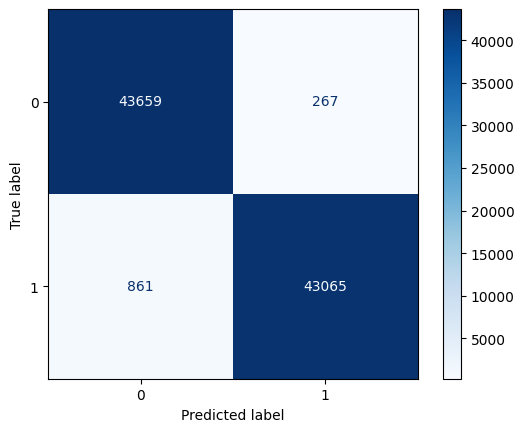

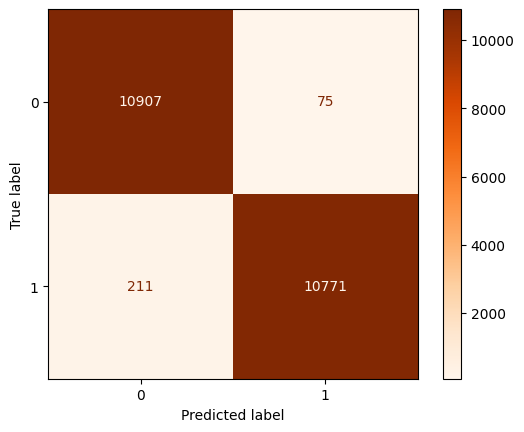

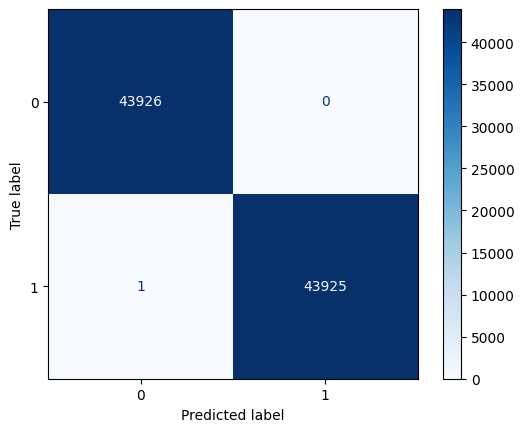

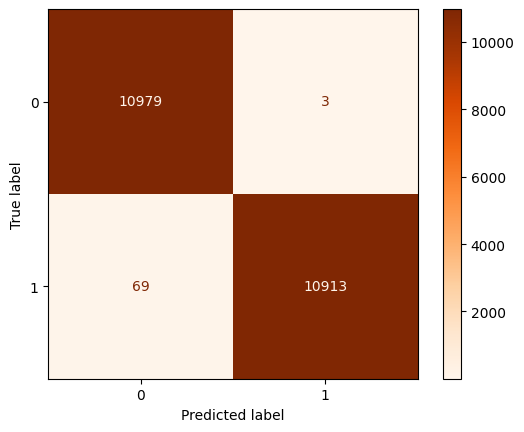

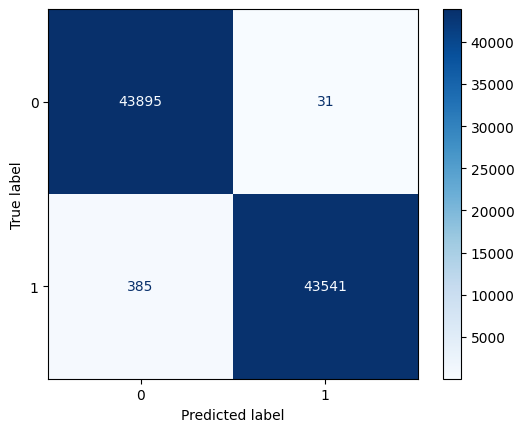

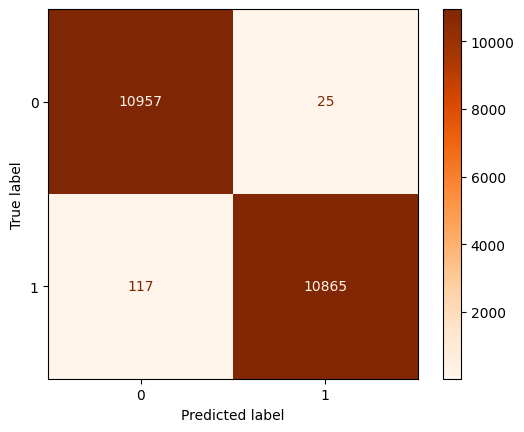

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from datetime import datetime

# --- Features & Label ---
X_columns = [col for col in df.columns if col not in ["label", "original_label", "label_34"]]
y_column = "label"

# --- Split dataset into train and test ---
X_train, X_test, y_train, y_test = train_test_split(
    df[X_columns], df[y_column], test_size=0.2, random_state=42, stratify=df[y_column]
)

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Define models ---
ML_models = [
    ("LogisticRegression", LogisticRegression(n_jobs=-1,class_weight='balanced', max_iter=1000), "logreg-model.pkl"),
    ("RandomForestClassifier", RandomForestClassifier(class_weight='balanced', n_jobs=-1), "rf-model.pkl"),
    ("MLPClassifier", MLPClassifier(hidden_layer_sizes=(128,64,32), activation="relu", solver="adam",
                                    max_iter=50, learning_rate="adaptive", early_stopping=True,
                                    validation_fraction=0.1, batch_size=256, random_state=42, verbose=True),
     "mlp-model.pkl")
]

# --- Train & evaluate ---
for name, model, model_file in ML_models:
    print(datetime.now(), f" : Training {name} ...")
    model.fit(X_train_scaled, y_train)
    print(datetime.now(), f" : Training {name} complete!")
    
    # Save model + scaler
    with open(model_file, "wb") as f:
        pickle.dump((model, scaler), f)
    
    # --- TRAIN RESULTS ---
    y_train_pred = model.predict(X_train_scaled)
    print(f"\n{name} - TRAIN RESULTS")
    print("Accuracy :", accuracy_score(y_train, y_train_pred))
    print("Precision:", precision_score(y_train, y_train_pred, average="macro"))
    print("Recall   :", recall_score(y_train, y_train_pred, average="macro"))
    print("F1 Score :", f1_score(y_train, y_train_pred, average="macro"))
    cm_train = confusion_matrix(y_train, y_train_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(cmap="Blues", values_format="d")
    
    # --- TEST RESULTS ---
    y_test_pred = model.predict(X_test_scaled)
    print(f"\n{name} - TEST RESULTS")
    print("Accuracy :", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, average="macro"))
    print("Recall   :", recall_score(y_test, y_test_pred, average="macro"))
    print("F1 Score :", f1_score(y_test, y_test_pred, average="macro"))
    cm_test = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(cmap="Oranges", values_format="d")


2025-09-28 05:57:30.072535  : Fit LogisticRegression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2025-09-28 05:57:31.895702  : Fit LogisticRegression model complete...

##### LogisticRegression - TRAIN RESULTS #####
Accuracy : 0.9872331900633787
Precision: 0.9873188553207514
Recall   : 0.9872331900633787
F1 Score : 0.987232628972774


  0%|          | 0/3 [00:43<?, ?it/s]



##### LogisticRegression - TEST RESULTS #####
Accuracy : 0.9630600089576158
Precision: 0.6639616357098013
Recall   : 0.7831288866475796
F1 Score : 0.705867812527868
2025-09-28 05:58:31.295080  : Fit RandomForestClassifier model...
2025-09-28 05:58:49.043155  : Fit RandomForestClassifier model complete...

##### RandomForestClassifier - TRAIN RESULTS #####
Accuracy : 0.9999908938588183
Precision: 0.9999908940246589
Recall   : 0.9999908938588185
F1 Score : 0.9999908938588176


  0%|          | 0/3 [01:11<?, ?it/s]



##### RandomForestClassifier - TEST RESULTS #####
Accuracy : 0.02365136153832808
Precision: 0.31688212094672086
Recall   : 0.4953957098798576
F1 Score : 0.023137033462926858
CPU times: user 2min 30s, sys: 12.6 s, total: 2min 42s
Wall time: 2min 38s


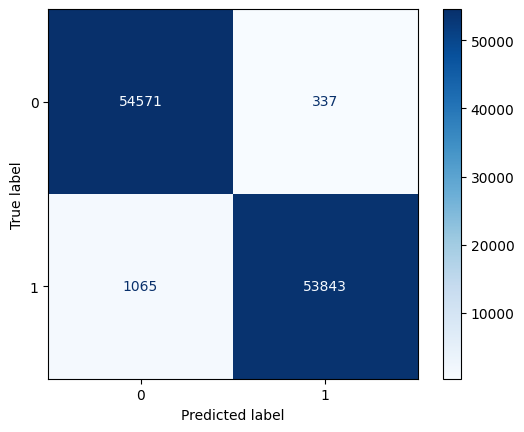

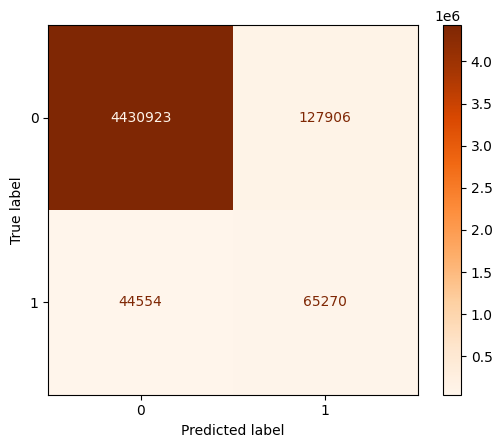

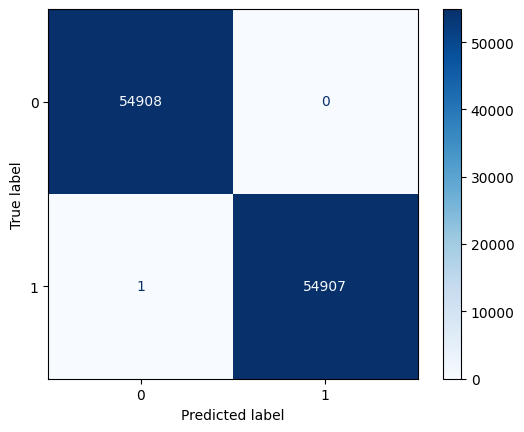

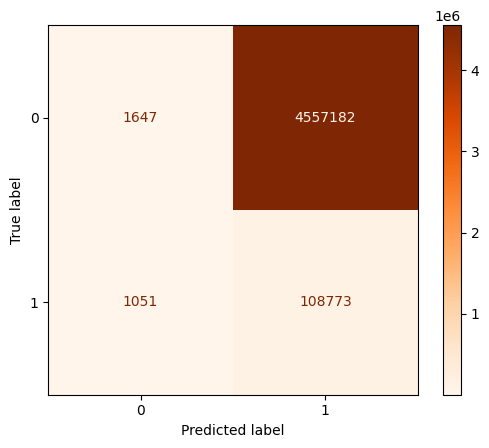

In [73]:
# %%time
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# import pickle
# from datetime import datetime

# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# ML_models = [
#     ("LogisticRegression", LogisticRegression(n_jobs=-1,class_weight='balanced'), f"logreg-{class_size}class-model.pkl"),
#     ("RandomForestClassifier", RandomForestClassifier(class_weight='balanced'), f"rf-{class_size}class-model.pkl")
#     #("MLPClassifier", MLPClassifier(), f"mlp-{class_size}class-model.pkl")
# ]

# # def train_and_evaluate(name, model, model_file, df):
# #     print(datetime.now(), f" : Fit {name} model...")
# #     model.fit(df[X_columns], df[y_column])
# #     print(datetime.now(), f" : Fit {name} model complete...")
    
# #     with open(model_file, "wb") as f:
# #         pickle.dump(model, f)
    
# #     y_test = []
# #     preds = []
# #     for test_set in tqdm(test_sets):
# #         d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
        
# #         # DEBUG: Check what columns are in test data
# #         print(f"Test file columns: {d_test.columns.tolist()}")
# #         print(f"Test file shape: {d_test.shape}")
        
# #         # Find the label column (might be named differently)
# #         if 'label' in d_test.columns:
# #             label_col = 'label'
# #         elif 'target' in d_test.columns:
# #             label_col = 'target'
# #         elif 'class' in d_test.columns:
# #             label_col = 'class'
# #         else:
# #             # Assume last column is the label
# #             label_col = d_test.columns[-1]
            
# #         print(f"Using label column: '{label_col}'")
# #         print(f"Sample labels: {d_test[label_col].unique()[:5]}")
        
# #         # PREPROCESS TEST DATA SAME AS TRAINING DATA
# #         # Handle protocol_type encoding
# #         d_test['protocol_type'] = le.transform(d_test['protocol_type'])
        
# #         # Convert boolean columns to int
# #         bool_columns = d_test.select_dtypes(include=['bool']).columns
# #         d_test[bool_columns] = d_test[bool_columns].astype(int)
        
# #         # Handle any remaining non-numeric columns
# #         for col in X_columns:
# #             if d_test[col].dtype == 'object':
# #                 d_test[col] = le.transform(d_test[col].astype(str))
        
# #         # Apply scaler to preprocessed data
# #         d_test[X_columns] = scaler.transform(d_test[X_columns])
        
# #         # Process labels - use the same string-to-binary mapping as training
# #         if binary_classifier:
# #             d_test[label_col] = d_test[label_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)
        
# #         y_test += list(d_test[label_col].values)
# #         y_pred = list(model.predict(d_test[X_columns]))
# #         preds += y_pred
        
# #         break  # Only process first test file for debugging
        
# #     print(f"##### {name} ({class_size} classes) #####")
# #     print('accuracy_score: ', accuracy_score(preds, y_test))
# #     print('recall_score: ', recall_score(preds, y_test, average='macro'))
# #     print('precision_score: ', precision_score(preds, y_test, average='macro'))
# #     print('f1_score: ', f1_score(preds, y_test, average='macro'))
# #     print('\n')
# # for name, model, model_file in ML_models:
# #     train_and_evaluate(name, model, model_file, df)

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# def train_and_evaluate(name, model, model_file, df):
#     print(datetime.now(), f" : Fit {name} model...")
#     model.fit(df[X_columns], df[y_column])
#     print(datetime.now(), f" : Fit {name} model complete...")
    
#     with open(model_file, "wb") as f:
#         pickle.dump(model, f)

    
    
#     # ----------- TRAIN EVALUATION -----------
#     y_train = df[y_column]
#     y_train_pred = model.predict(df[X_columns])
    
#     print(f"\n##### {name} - TRAIN RESULTS #####")
#     print("Accuracy :", accuracy_score(y_train, y_train_pred))
#     print("Precision:", precision_score(y_train, y_train_pred, average="macro"))
#     print("Recall   :", recall_score(y_train, y_train_pred, average="macro"))
#     print("F1 Score :", f1_score(y_train, y_train_pred, average="macro"))
    
#     cm_train = confusion_matrix(y_train, y_train_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(cmap="Blues", values_format="d")
    
#     # ----------- TEST EVALUATION -----------
#     y_test, preds = [], []
#     for test_set in tqdm(test_sets):
#         d_test = pd.read_csv(DATASET_DIRECTORY + test_set)

#         # pick correct label column
#         if 'label' in d_test.columns:
#             label_col = 'label'
#         elif 'target' in d_test.columns:
#             label_col = 'target'
#         elif 'class' in d_test.columns:
#             label_col = 'class'
#         else:
#             label_col = d_test.columns[-1]

#         # preprocessing same as before
#         # d_test['protocol_type'] = le.transform(d_test['protocol_type'])
#         if 'protocol_type' in d_test.columns:
#             d_test['protocol_type'] = d_test['protocol_type'].astype(str)
#             d_test['protocol_type'] = d_test['protocol_type'].map(
#            lambda x: x if x in le.classes_ else le.classes_[0] )# fallback
#         d_test['protocol_type'] = le.transform(d_test['protocol_type'])

#         bool_columns = d_test.select_dtypes(include=['bool']).columns
#         d_test[bool_columns] = d_test[bool_columns].astype(int)
#         for col in X_columns:
#             if d_test[col].dtype == 'object':
#                 d_test[col] = le.transform(d_test[col].astype(str))
#         d_test[X_columns] = scaler.transform(d_test[X_columns])
        
#         if binary_classifier:
#             d_test[label_col] = d_test[label_col].astype(int)  # True->1 (Benign), False->0 (Attack)
#             #d_test[label_col] = d_test[label_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)
        
#         y_test = d_test[label_col].values
#         preds = model.predict(d_test[X_columns])
#         break   # only first test set for now
    
#     print(f"\n##### {name} - TEST RESULTS #####")
#     print("Accuracy :", accuracy_score(y_test, preds))
#     print("Precision:", precision_score(y_test, preds, average="macro"))
#     print("Recall   :", recall_score(y_test, preds, average="macro"))
#     print("F1 Score :", f1_score(y_test, preds, average="macro"))
    
#     cm_test = confusion_matrix(y_test, preds)
#     ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(cmap="Oranges", values_format="d")

# for name, model, model_file in ML_models:
#     train_and_evaluate(name, model, model_file, df)

2025-09-28 06:00:34.250401  : Preprocessing data for MLP...
Class weights: {0: 1.0, 1: 1.0}
2025-09-28 06:00:34.367083  : Training MLP...
Iteration 1, loss = 0.06628524
Validation score: 0.989984
Iteration 2, loss = 0.03417465
Validation score: 0.990894
Iteration 3, loss = 0.03076208
Validation score: 0.991441
Iteration 4, loss = 0.02923408
Validation score: 0.991167
Iteration 5, loss = 0.02868865
Validation score: 0.991714
Iteration 6, loss = 0.02762360
Validation score: 0.992351
Iteration 7, loss = 0.02651929
Validation score: 0.991896
Iteration 8, loss = 0.02639559
Validation score: 0.991441
Iteration 9, loss = 0.02571188
Validation score: 0.992169
Iteration 10, loss = 0.02543562
Validation score: 0.992260
Iteration 11, loss = 0.02518503
Validation score: 0.992260
Iteration 12, loss = 0.02494711
Validation score: 0.991987
Iteration 13, loss = 0.02446361
Validation score: 0.991987
Iteration 14, loss = 0.02408276
Validation score: 0.992533
Iteration 15, loss = 0.02396564
Validation sc

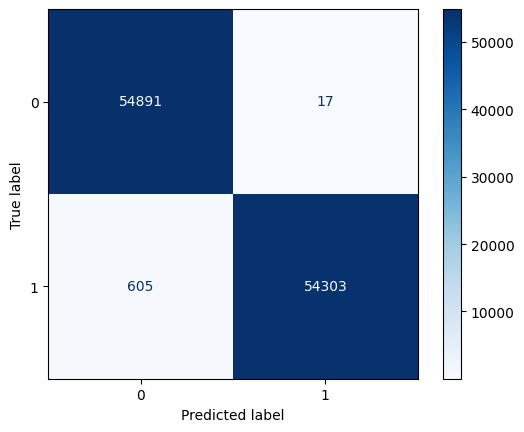

In [74]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# import pickle

# def train_and_evaluate_nn(df, X_columns, y_column, model_file="mlp-model.pkl"):
#     print(datetime.now(), " : Preprocessing data for MLP...")

#     # Scale features (very important for NN!)
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(df[X_columns])
#     y = df[y_column].values

#     # Compute class weights
#     class_weights = compute_class_weight(class_weight='balanced',
#                                          classes=np.unique(y),
#                                          y=y)
#     class_weights = dict(zip(np.unique(y), class_weights))
#     print("Class weights:", class_weights)

#     # Define MLP model
#     mlp = MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),  
#         activation="relu",
#         solver="adam",
#         max_iter=50,                       
#         learning_rate="adaptive",
#         early_stopping=True,
#         validation_fraction=0.1,
#         batch_size=256,
#         random_state=42,
#         verbose=True
#     )

#     print(datetime.now(), " : Training MLP...")
#     mlp.fit(X_scaled, y)

#     print(datetime.now(), " : Training complete!")

#     # Save model + scaler
#     with open(model_file, "wb") as f:
#         pickle.dump((mlp, scaler), f)

#     # --- TRAIN EVAL ---
#     y_train_pred = mlp.predict(X_scaled)
#     print("\n##### MLP - TRAIN RESULTS #####")
#     print("Accuracy :", accuracy_score(y, y_train_pred))
#     print("Precision:", precision_score(y, y_train_pred, average="macro"))
#     print("Recall   :", recall_score(y, y_train_pred, average="macro"))
#     print("F1 Score :", f1_score(y, y_train_pred, average="macro"))

#     cm_train = confusion_matrix(y, y_train_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(cmap="Blues", values_format="d")

#     return mlp, scaler

# mlp_model, mlp_scaler = train_and_evaluate_nn(df, X_columns, y_column, model_file="mlp-model.pkl")


2025-09-28 06:06:53.670144  : Preprocessing data for MLP...
Class weights: {0: 1.0, 1: 1.0}
2025-09-28 06:06:53.785897  : Training MLP...
Iteration 1, loss = 0.06628524
Validation score: 0.989984
Iteration 2, loss = 0.03417465
Validation score: 0.990894
Iteration 3, loss = 0.03076208
Validation score: 0.991441
Iteration 4, loss = 0.02923408
Validation score: 0.991167
Iteration 5, loss = 0.02868865
Validation score: 0.991714
Iteration 6, loss = 0.02762360
Validation score: 0.992351
Iteration 7, loss = 0.02651929
Validation score: 0.991896
Iteration 8, loss = 0.02639559
Validation score: 0.991441
Iteration 9, loss = 0.02571188
Validation score: 0.992169
Iteration 10, loss = 0.02543562
Validation score: 0.992260
Iteration 11, loss = 0.02518503
Validation score: 0.992260
Iteration 12, loss = 0.02494711
Validation score: 0.991987
Iteration 13, loss = 0.02446361
Validation score: 0.991987
Iteration 14, loss = 0.02408276
Validation score: 0.992533
Iteration 15, loss = 0.02396564
Validation sc

Evaluating Test Sets: 100%|██████████| 3/3 [01:55<00:00, 38.42s/it]



##### MLP - TEST RESULTS #####
Accuracy : 0.020579026398692156
Precision: 0.31443258550128306
Recall   : 0.26112529873112833
F1 Score : 0.02055830296375039


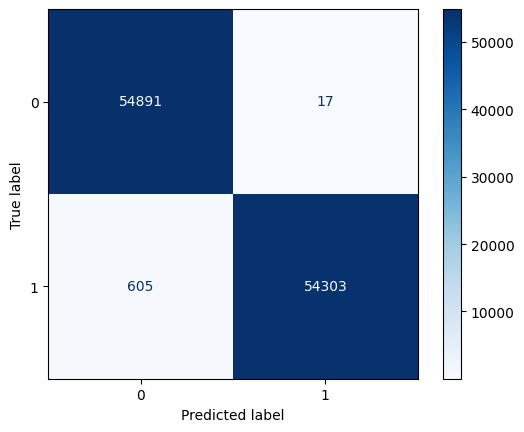

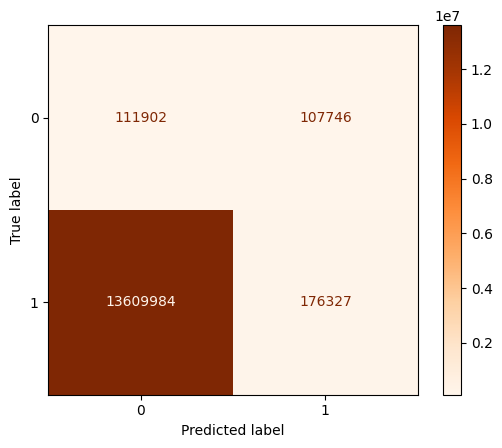

In [78]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# import pickle
# import pandas as pd
# from datetime import datetime
# from tqdm import tqdm

# def train_and_evaluate_nn(df, X_columns, y_column, test_sets, DATASET_DIRECTORY, binary_classifier=True, model_file="mlp-model.pkl"):
#     print(datetime.now(), " : Preprocessing data for MLP...")

#     # ---- TRAIN PREPROCESSING ----
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(df[X_columns])
#     y = df[y_column].values

#     # Compute class weights (helps with imbalance)
#     class_weights = compute_class_weight(class_weight='balanced',
#                                          classes=np.unique(y),
#                                          y=y)
#     class_weights = dict(zip(np.unique(y), class_weights))
#     print("Class weights:", class_weights)

#     # Define MLP model
#     mlp = MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),  
#         activation="relu",
#         solver="adam",
#         max_iter=50,
#         learning_rate="adaptive",
#         early_stopping=True,
#         validation_fraction=0.1,
#         batch_size=256,
#         random_state=42,
#         verbose=True
#     )

#     # ---- TRAIN ----
#     print(datetime.now(), " : Training MLP...")
#     mlp.fit(X_scaled, y)
#     print(datetime.now(), " : Training complete!")

#     # Save model + scaler
#     with open(model_file, "wb") as f:
#         pickle.dump((mlp, scaler), f)

#     # ---- TRAIN EVAL ----
#     y_train_pred = mlp.predict(X_scaled)
#     print("\n##### MLP - TRAIN RESULTS #####")
#     print("Accuracy :", accuracy_score(y, y_train_pred))
#     print("Precision:", precision_score(y, y_train_pred, average="macro"))
#     print("Recall   :", recall_score(y, y_train_pred, average="macro"))
#     print("F1 Score :", f1_score(y, y_train_pred, average="macro"))

#     cm_train = confusion_matrix(y, y_train_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(cmap="Blues", values_format="d")

#     # ---- TEST EVAL ----
#     all_preds, all_true = [], []
#     for test_set in tqdm(test_sets, desc="Evaluating Test Sets"):
#         d_test = pd.read_csv(DATASET_DIRECTORY + test_set)

#         # pick correct label column
#         if 'label' in d_test.columns:
#             label_col = 'label'
#         elif 'target' in d_test.columns:
#             label_col = 'target'
#         elif 'class' in d_test.columns:
#             label_col = 'class'
#         else:
#             label_col = d_test.columns[-1]

#         # --- preprocess test data ---
#         # Ensure categorical features are numeric (example for protocol_type)
#         if 'protocol_type' in d_test.columns:
#             d_test['protocol_type'] = d_test['protocol_type'].astype('category').cat.codes

#         # convert boolean → int
#         bool_columns = d_test.select_dtypes(include=['bool']).columns
#         d_test[bool_columns] = d_test[bool_columns].astype(int)

#         # scale features
#         X_test_scaled = scaler.transform(d_test[X_columns])

#         # binary mapping for labels
#         if binary_classifier:
#             d_test[label_col] = d_test[label_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)

#         y_test = d_test[label_col].values
#         preds = mlp.predict(X_test_scaled)

#         all_true.extend(y_test)
#         all_preds.extend(preds)

#         # only break if you want first file
#         # break  

#     print("\n##### MLP - TEST RESULTS #####")
#     print("Accuracy :", accuracy_score(all_true, all_preds))
#     print("Precision:", precision_score(all_true, all_preds, average="macro"))
#     print("Recall   :", recall_score(all_true, all_preds, average="macro"))
#     print("F1 Score :", f1_score(all_true, all_preds, average="macro"))

#     cm_test = confusion_matrix(all_true, all_preds)
#     ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(cmap="Oranges", values_format="d")

#     return mlp, scaler



# mlp_model, mlp_scaler = train_and_evaluate_nn(
#     df=df,
#     X_columns=X_columns,
#     y_column=y_column,
#     test_sets=test_sets,
#     DATASET_DIRECTORY=DATASET_DIRECTORY,
#     binary_classifier=True,         # True if you mapped Benign=0, Attack=1
#     model_file="mlp-model.pkl"
# )



# Calculate Test Performance metrics

In [26]:
# y_test = []
# preds = {i:[] for i in range(len(ML_models))}
# for test_set in tqdm(test_sets):
#     d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    
#     # PREPROCESS TEST DATA FIRST (same as training data)
#     # Handle protocol_type encoding
#     d_test['protocol_type'] = le.transform(d_test['protocol_type'])
    
#     # Convert boolean columns to int
#     bool_columns = d_test.select_dtypes(include=['bool']).columns
#     d_test[bool_columns] = d_test[bool_columns].astype(int)
    
#     # Handle any remaining non-numeric columns
#     for col in X_columns:
#         if d_test[col].dtype == 'object':
#             d_test[col] = le.transform(d_test[col].astype(str))
    
#     # NOW apply scaler to preprocessed data
#     d_test[X_columns] = scaler.transform(d_test[X_columns])
    
#     # Handle labels - different test files have different label formats
#     if 'benign' in d_test.columns:
#         # Boolean format: True/False
#         d_test[y_column] = d_test['benign'].astype(int)
#     elif y_column in d_test.columns:
#         # Check if labels are strings (need binary mapping) or already numeric
#         if d_test[y_column].dtype == 'object':
#             # String labels - map to binary (same as training data)
#             d_test[y_column] = d_test[y_column].apply(lambda x: 0 if 'Benign' in str(x) else 1)
#         else:
#             # Already numeric
#             d_test[y_column] = d_test[y_column].astype(int)
#     else:
#         # Use last column as label
#         last_col = d_test.columns[-1]
#         if d_test[last_col].dtype == 'object':
#             d_test[y_column] = d_test[last_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)
#         else:
#             d_test[y_column] = d_test[last_col].astype(int)
    
#     y_test += list(d_test[y_column].values)
    
#     # Get predictions from all models
#     for i, (name, model, model_file) in enumerate(ML_models):
#         y_pred = list(model.predict(d_test[X_columns]))
#         preds[i] = preds[i] + y_pred

In [ ]:
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# # Get model names for display
# ML_names = [name for name, model, model_file in ML_models]

# print("Model Evaluation Results:")
# print("=" * 50)

# for k, v in preds.items():
#     y_pred = v
#     model_name = ML_names[k]
    
#     print(f"##### {model_name} ({class_size} classes) #####")
#     print(f'Accuracy Score: {accuracy_score(y_pred, y_test):.4f}')
#     print(f'Recall Score: {recall_score(y_pred, y_test, average="macro"):.4f}')
#     print(f'Precision Score: {precision_score(y_pred, y_test, average="macro"):.4f}')
#     print(f'F1 Score: {f1_score(y_pred, y_test, average="macro"):.4f}')
#     print()